In [2]:
%matplotlib inline
import os

import numpy as np
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [8, 6]
from metavision_core.event_io import RawReader
from metavision_ml.preprocessing import histo
from metavision_ml.preprocessing.viz import viz_histo

: 

[['0_5', '0', 'recording_2024-10-02_10-26-52.raw'], ['1', '0', 'recording_2024-10-02_10-30-16.raw'], ['1_5', '0', 'recording_2024-10-02_10-31-29.raw'], ['2', '0', 'recording_2024-10-02_11-06-14.raw'], ['2_5', '0', 'recording_2024-10-02_11-09-53.raw']]


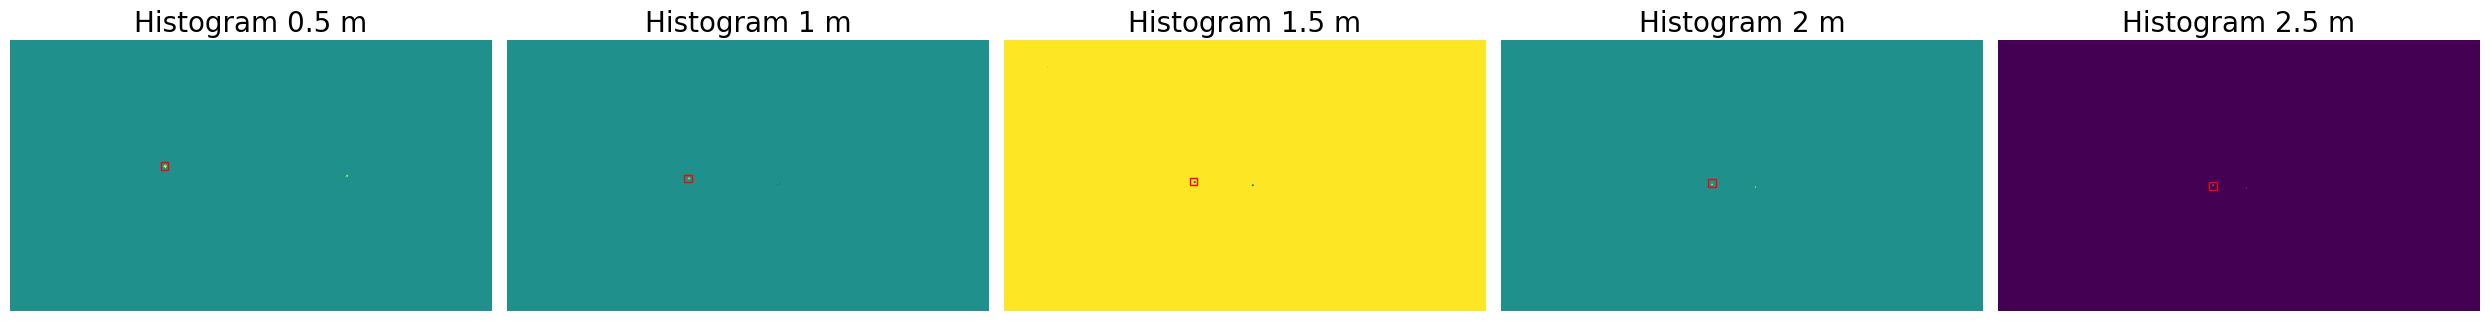

In [5]:
dir_path = ["uvled_freq_dataset", "recordings", "5k"]
dir_path = os.path.join(*dir_path)

lables = ["0.5 m", "1 m", "1.5 m", "2 m", "2.5 m"]

#load recordings from the dataset, one for each distance
recordings = [
    ["0_5", "0", "recording_2024-10-02_10-26-52.raw"],
    ["1",   "0", "recording_2024-10-02_10-30-16.raw"],
    ["1_5", "0", "recording_2024-10-02_10-31-29.raw"],
    ["2",   "0", "recording_2024-10-02_11-06-14.raw"],
    ["2_5", "0", "recording_2024-10-02_11-09-53.raw"]
]

print(recordings)

recordings = list(map(lambda x: os.path.join(dir_path, *x), recordings))

raws = [RawReader(recording) for recording in recordings]

#size of the recording highlight
areasize = 20

#the areas for each recording
areas = [
    (400, 325),
    (470, 358),
    (493, 365),
    (550, 370),
    (560, 377)
]

# Number of histograms
num_histograms = len(raws)
rows = 1
cols = int(np.ceil(num_histograms / rows))

# Visualize the areas in the histograms
fig, axes = plt.subplots(rows, cols, figsize=(25, 25))
axes = axes.flatten()

for idx, raw in enumerate(raws):
    height, width = raw.get_size()
    start_ts = 0.5 * 1e6
    raw.seek_time(start_ts)

    delta_t = 500  # sampling duration
    events = raw.load_delta_t(delta_t)  # load 50 milliseconds worth of events
    events['t'] -= int(start_ts)  # important! almost all preprocessing use relative time!

    tbins = 4
    volume = np.zeros((tbins, 2, height, width), dtype=np.float32)
    histo(events, volume, delta_t)

    im = viz_histo(volume[2])
    ax = axes[idx]
    ax.imshow(im)
    ax.set_title(f'Histogram {lables[idx]}', fontsize=20)
    ax.axis('off')

    # Add a rectangle to highlight the area
    ax.add_patch(plt.Rectangle(areas[idx], areasize, areasize, fill=None, edgecolor='red'))

# Hide any unused subplots
for ax in axes[num_histograms:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

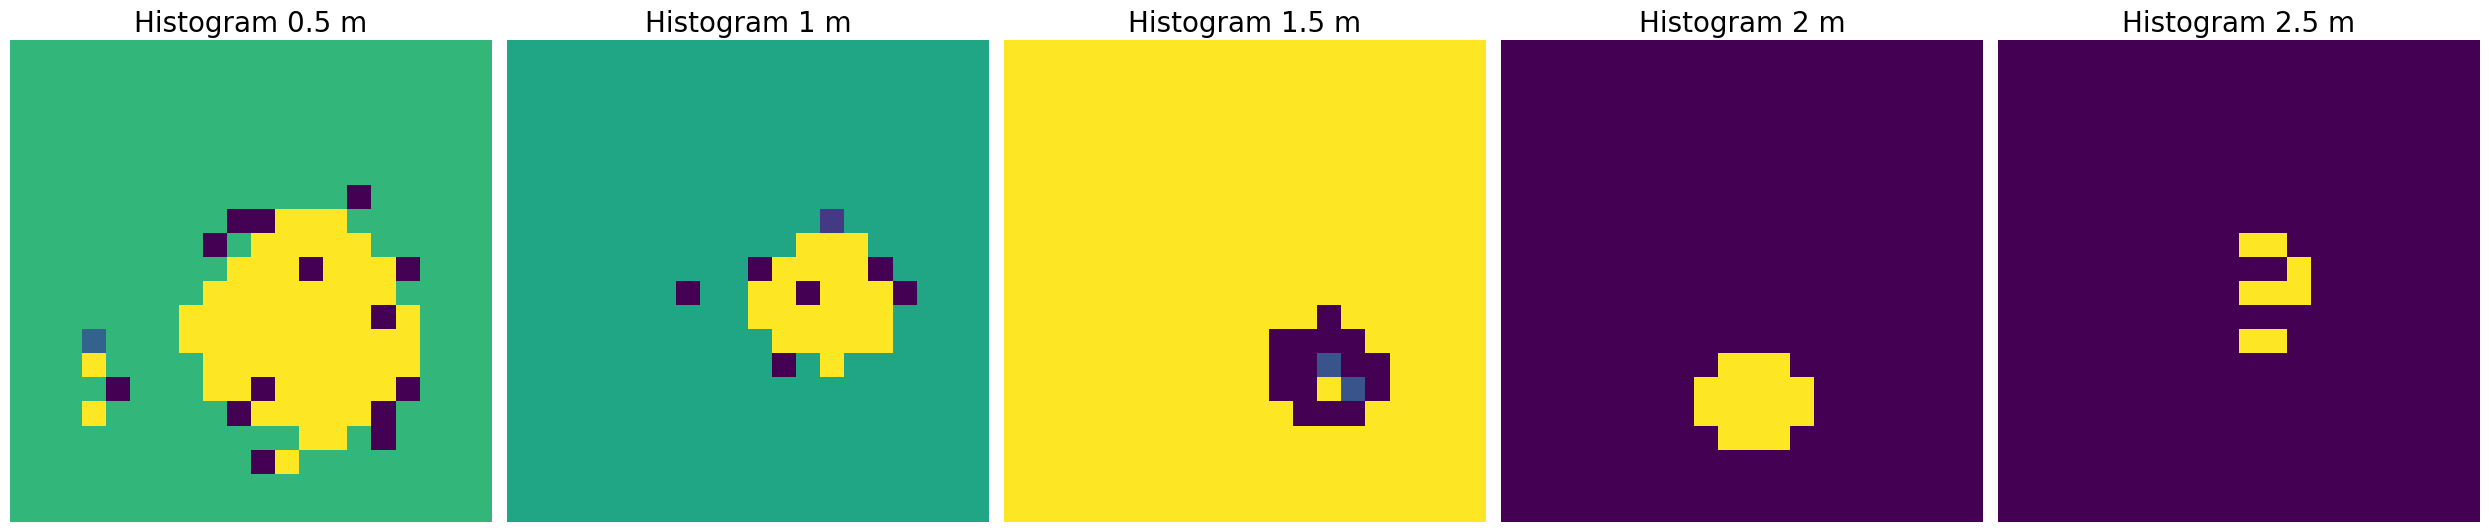

In [101]:
#size of the recording highlight
areasize = 20

#the areas for each recording
areas = [
	(400, 325),
	(470, 358),
	(493, 365),
	(550, 370),
	(560, 377)
]

# Number of histograms
num_histograms = len(raws)
#histograms for the cut areas

rows = 1
cols = int(np.ceil(num_histograms / rows))

# Visualize the areas in the histograms
fig, axes = plt.subplots(rows, cols, figsize=(25, 25))
axes = axes.flatten()

from util import filter_events

for raw in raws:
	raw.reset()

for idx, raw in enumerate(raws):
	height, width = raw.get_size()
	start_ts = 0.5 * 1e6
	raw.seek_time(start_ts)  # seek in the file to 1s

	delta_t = 500  # sampling duration
	events = raw.load_delta_t(delta_t)  # load 50 milliseconds worth of events
	events['t'] -= int(start_ts)  # important! almost all preprocessing use relative time!
	events = filter_events(events, areas[idx], areasize)

	tbins = 4
	volume = np.zeros((tbins, 2, height, width), dtype=np.float32)
	histo(events, volume, delta_t)

	# Calculate the coordinates of the bounding box
	x, y = areas[idx]
	cropped_volume = volume[:, :, y:y+areasize, x:x+areasize]

	im = viz_histo(cropped_volume[2])
	ax = axes[idx]
	ax.imshow(im)
	ax.set_title(f'Histogram {lables[idx]}', fontsize=20)
	ax.axis('off')

# Hide any unused subplots
for ax in axes[num_histograms:]:
	ax.axis('off')

plt.tight_layout()
plt.show()

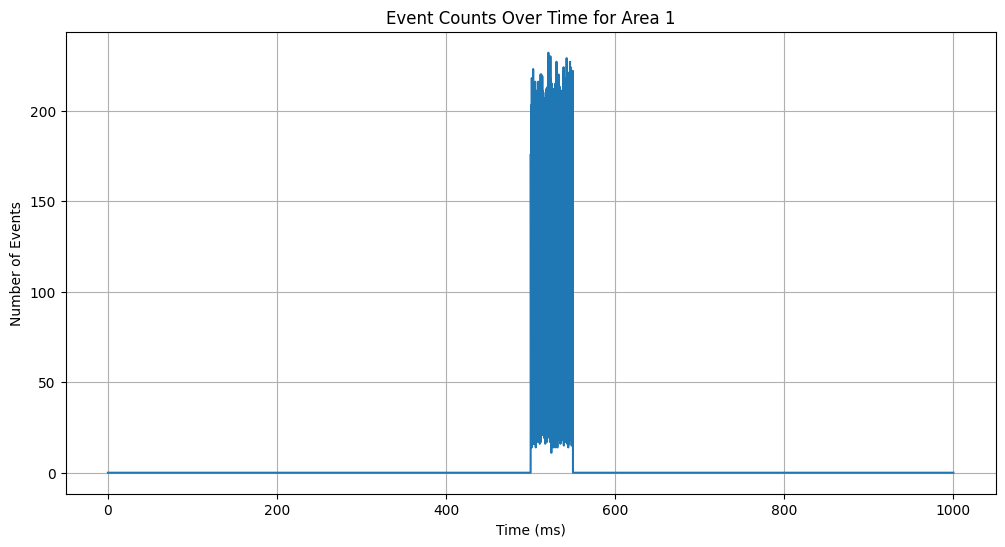

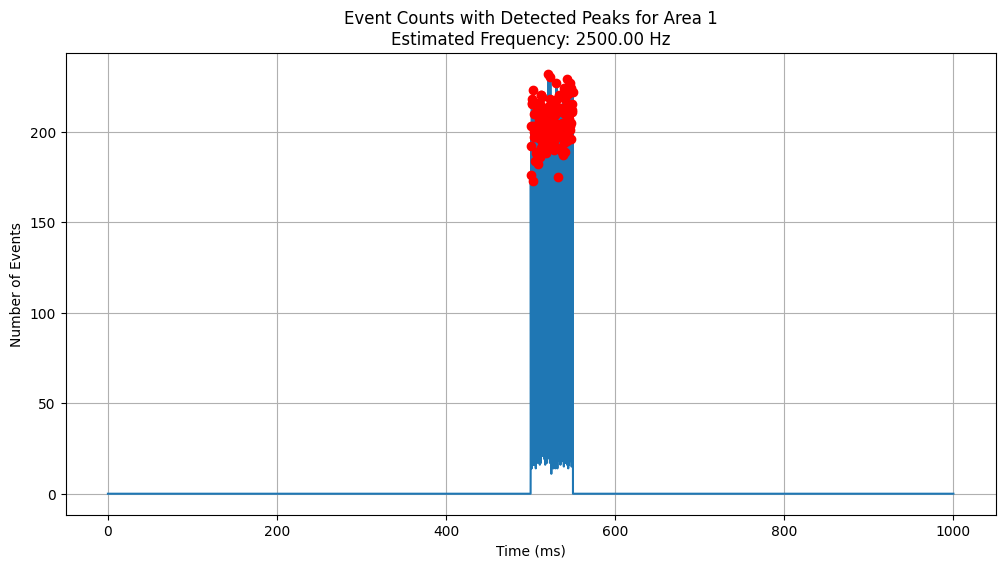

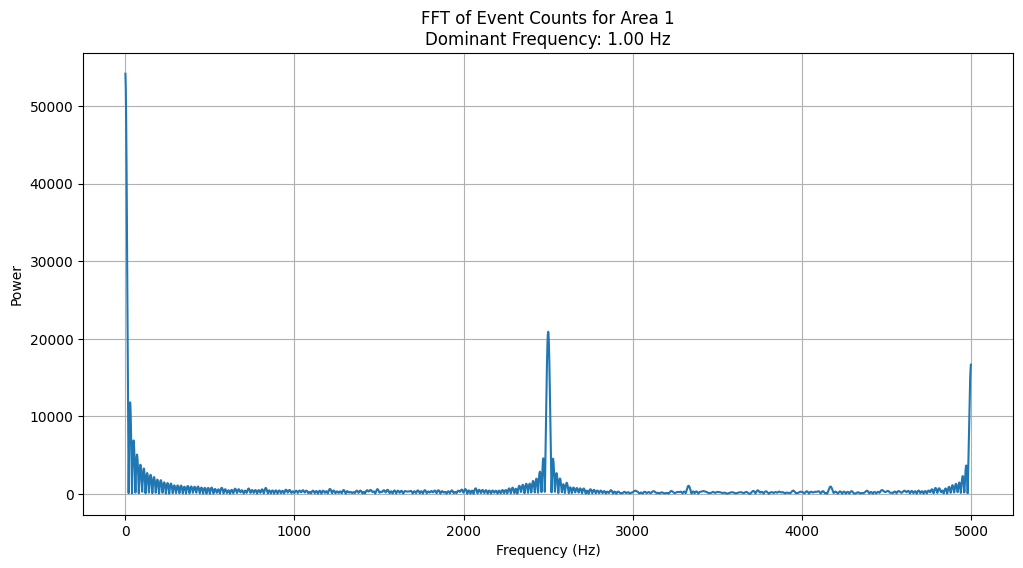

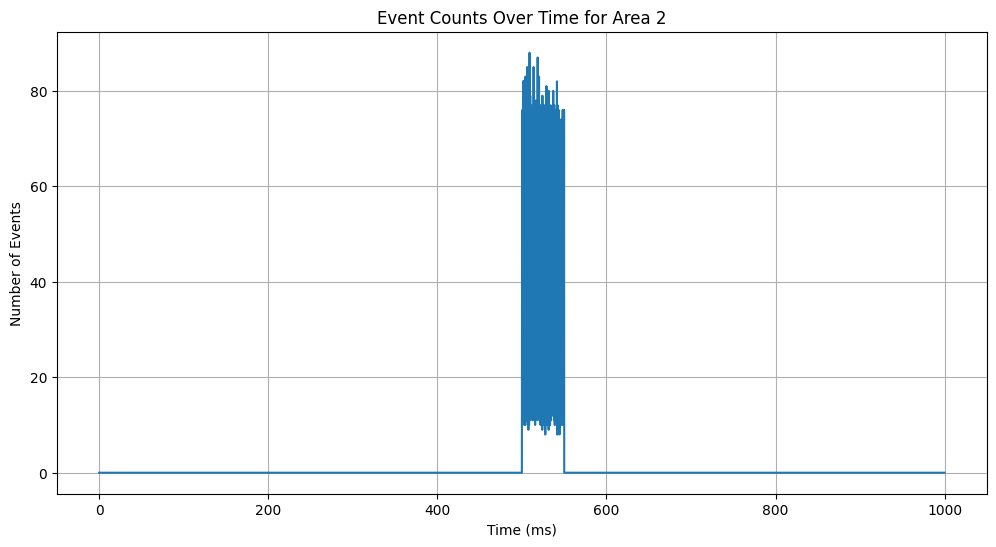

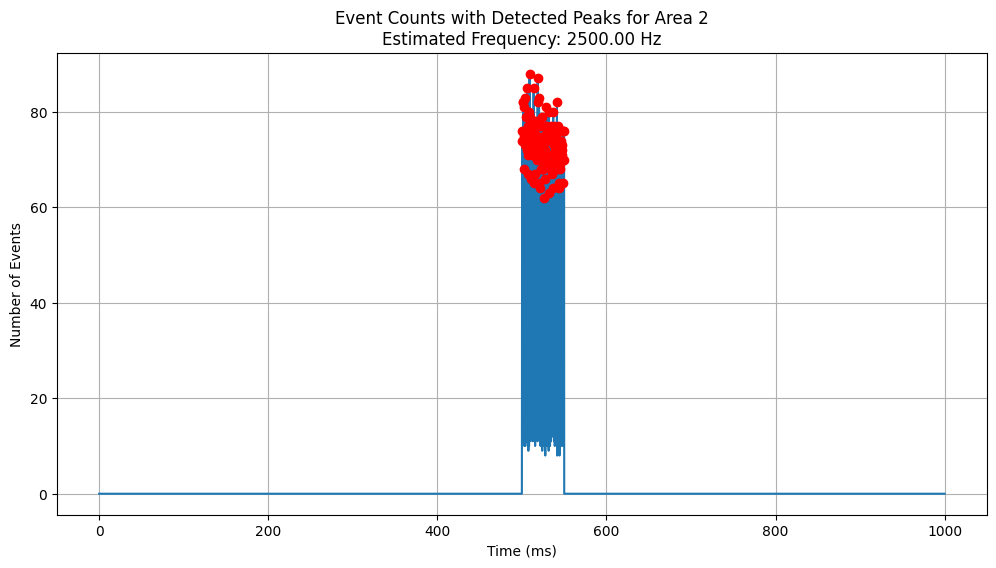

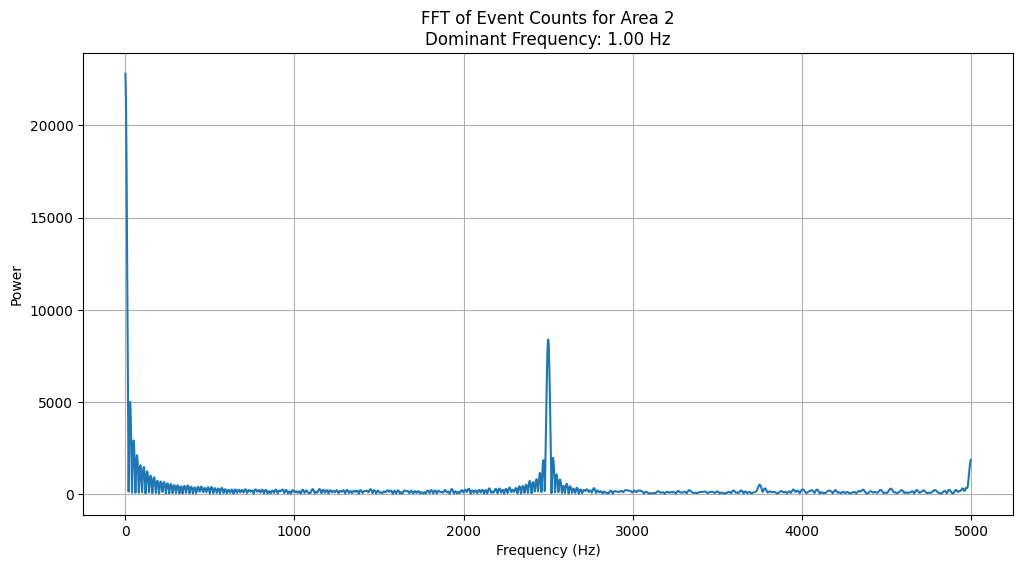

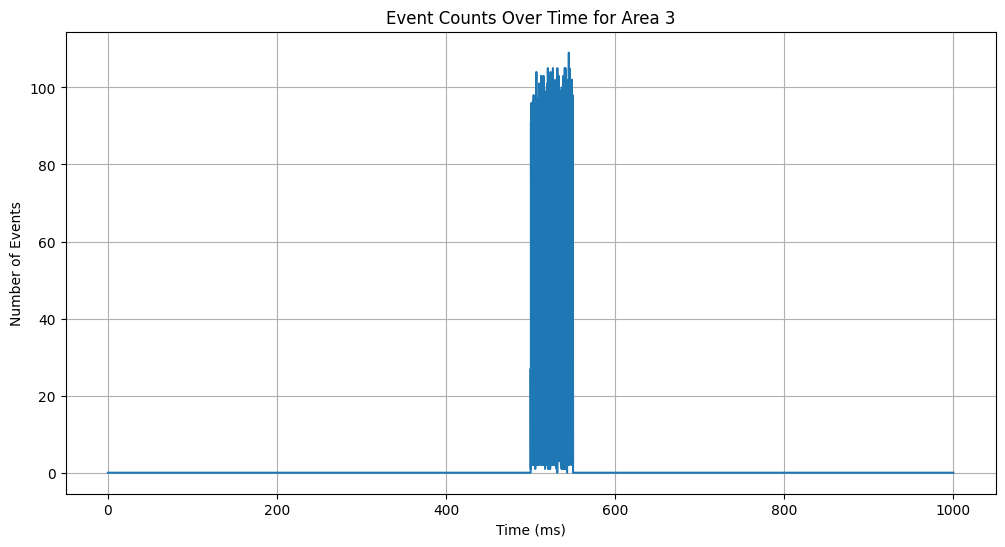

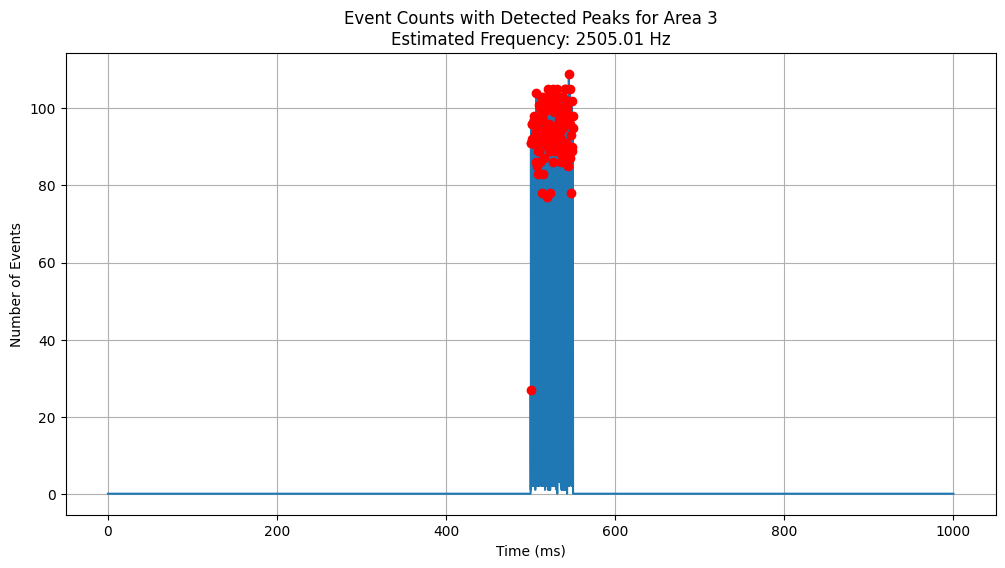

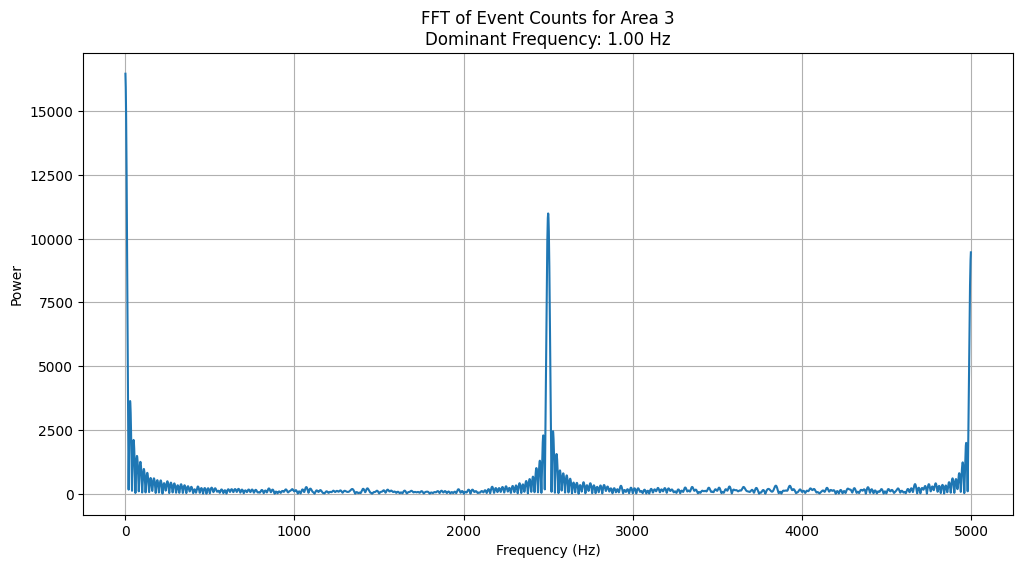

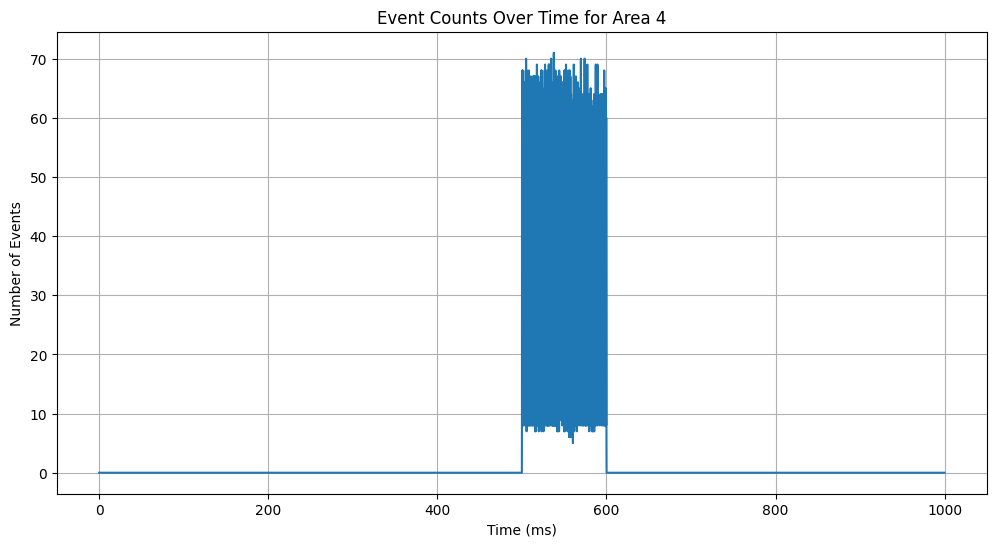

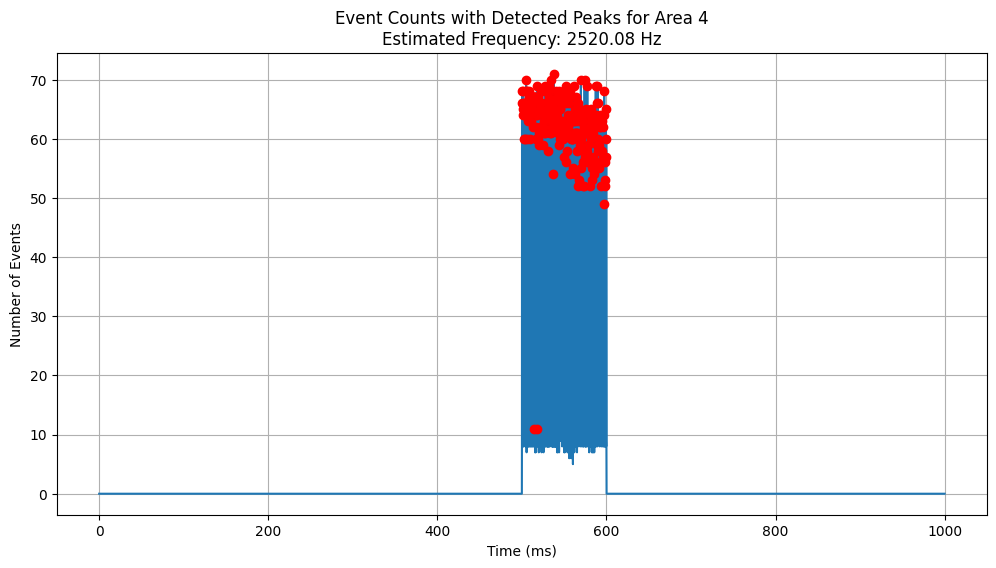

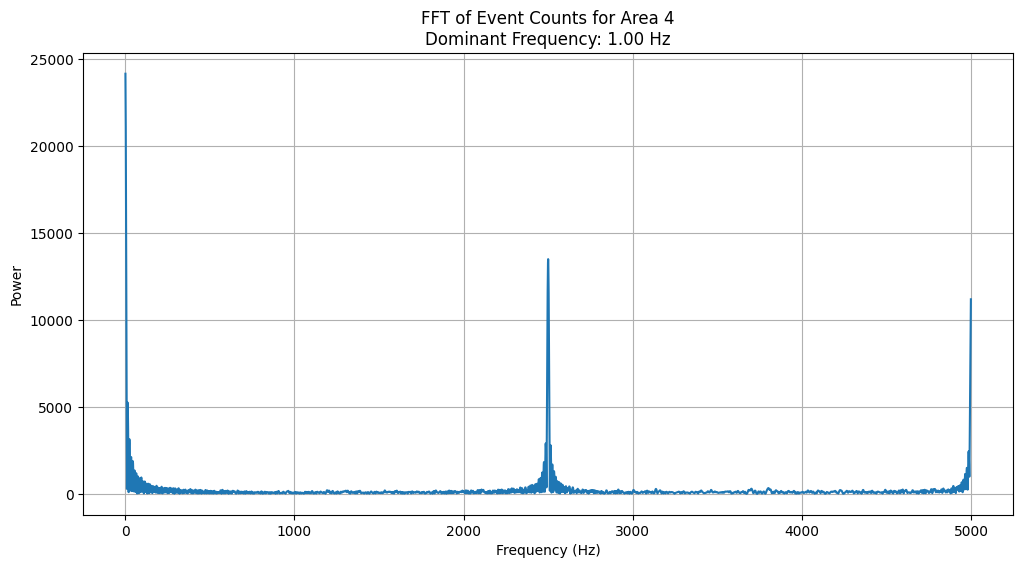

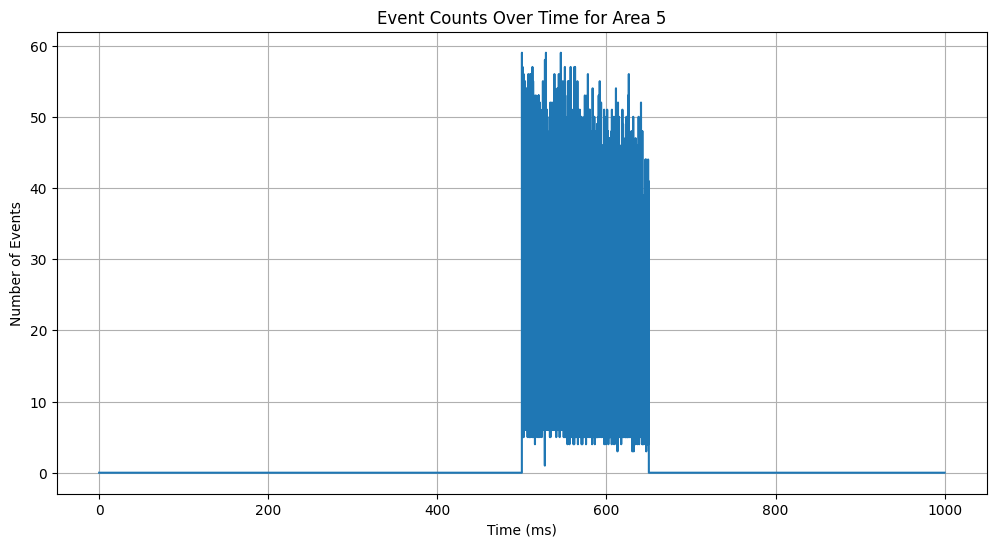

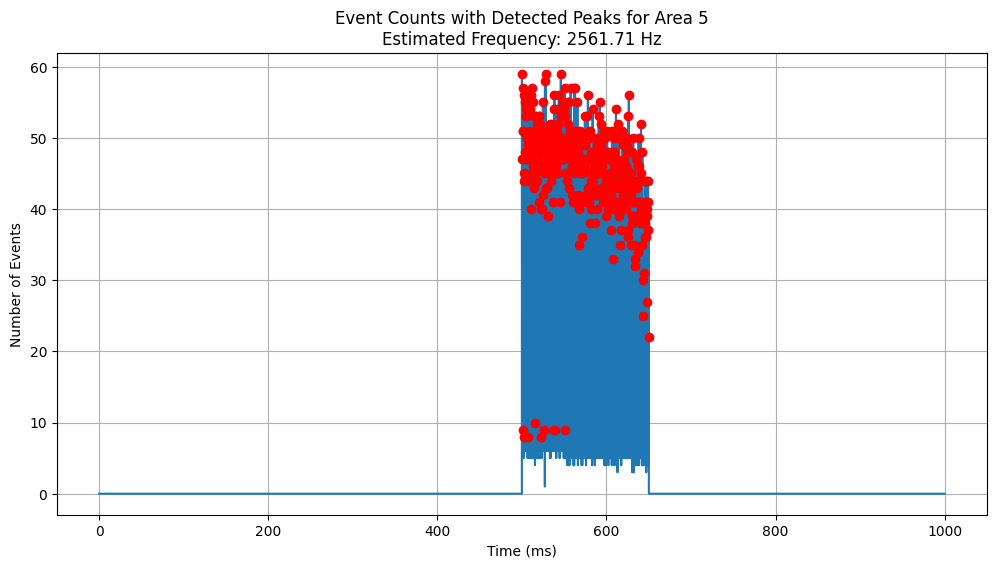

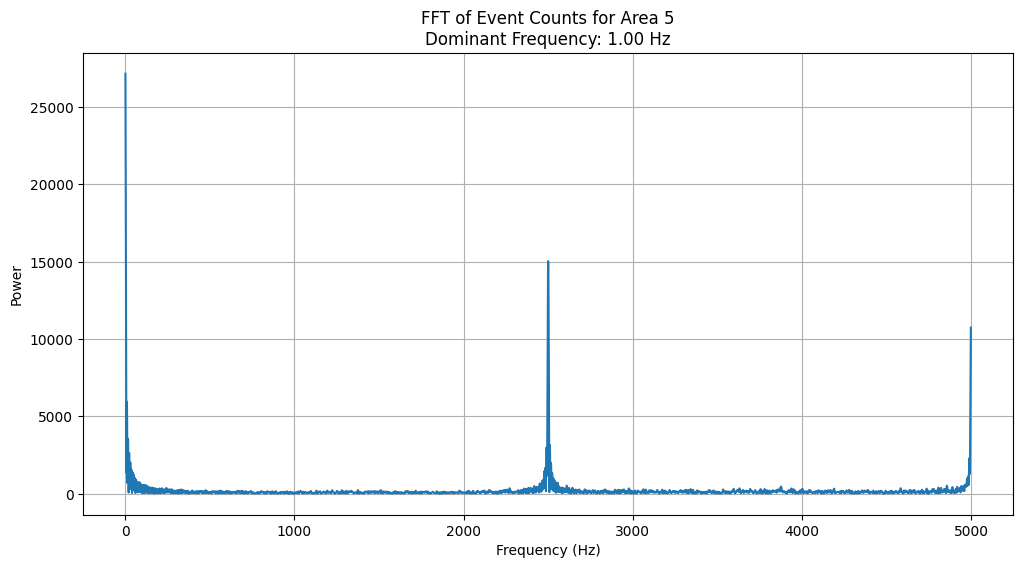

In [118]:
from scipy.signal import find_peaks

small_delta_t = 100
total_duration = 1e6

# number of bins
time_bins = np.arange(0, total_duration + small_delta_t, small_delta_t)
time_bins_ms = time_bins[:-1] / 1000  # convert to milliseconds

all_event_counts = []

for idx, raw in enumerate(raws):
	height, width = raw.get_size()
	raw.reset()  # Ensure we're at the beginning of the recording
	raw.seek_time(0.5 * 1e6)  # Seek to 0.5s

	# Load all events up to total_duration
	events = raw.load_n_events(-1)  # load all events
	events = events[events['t'] <= total_duration]  # keep events within the total_duration
	events = filter_events(events, areas[idx], areasize)

	# bin the events over time
	counts, _ = np.histogram(events['t'], bins=time_bins)
	all_event_counts.append(counts)

	# plot event counts over time
	plt.figure(figsize=(12, 6))
	plt.plot(time_bins_ms, counts)
	plt.title(f'Event Counts Over Time for Area {idx+1}')
	plt.xlabel('Time (ms)')
	plt.ylabel('Number of Events')
	plt.grid(True)
	plt.show()

	# Peak detection
	peaks, _ = find_peaks(counts, height=np.mean(counts))
	peak_times = time_bins_ms[peaks]
	if len(peak_times) > 1:
		periods = np.diff(peak_times)  # Time between peaks in ms
		estimated_frequency = 1000 / np.mean(periods)  # Frequency in Hz
	else:
		estimated_frequency = np.nan  # Not enough peaks to estimate frequency

	plt.figure(figsize=(12, 6))
	plt.plot(time_bins_ms, counts)
	plt.plot(peak_times, counts[peaks], 'ro')
	plt.title(f'Event Counts with Detected Peaks for Area {idx+1}\nEstimated Frequency: {estimated_frequency:.2f} Hz')
	plt.xlabel('Time (ms)')
	plt.ylabel('Number of Events')
	plt.grid(True)
	plt.show()

	# FFT analysis
	fft_result = np.fft.fft(counts)
	freqs = np.fft.fftfreq(len(counts), d=small_delta_t / 1e6)  # Convert delta_t to seconds
	idxs = np.where(freqs > 0)
	freqs = freqs[idxs]
	power = np.abs(fft_result[idxs])

	dominant_freq = freqs[np.argmax(power)]

	plt.figure(figsize=(12, 6))
	plt.plot(freqs, power)
	plt.title(f'FFT of Event Counts for Area {idx+1}\nDominant Frequency: {dominant_freq:.2f} Hz')
	plt.xlabel('Frequency (Hz)')
	plt.ylabel('Power')
	plt.grid(True)
	plt.show()